# Insurance Cost Prediction Analysis

### Project Overview

We study how demographic and lifestyle factors drive medical insurance costs. The goal is to build accurate regression models, explain the key drivers, and check that predictions remain fair across demographic groups. Recent discussions from regulators (for example the NAIC Special Committee on Race and Insurance) highlight how pricing variables such as credit score or zip code can become proxy discriminators. While those controversial fields are not present in this dataset, we still treat fairness as a first-class requirement.

Objectives:
1. Load and explore the `insurance.csv` dataset.
2. Engineer informative features that capture non-linear risk segments.
3. Train baseline models and evaluate them with cross-validation.
4. Use Optuna to tune Random Forest and XGBoost models.
5. Explain model behavior with feature importance, SHAP, and partial dependence plots.
6. Test for statistical fairness across sex and region groups.
7. Summarize actionable recommendations for insurers.

All code cells rely on Python 3.12 with pandas, scikit-learn, Optuna, XGBoost, and SHAP already installed in the environment.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.stats import f_oneway, ttest_ind
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Configure plotting style and output folder
sns.set_theme(style="whitegrid", palette="husl")
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

def savefig(name: str) -> Path:
    path = FIG_DIR / name
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print(f"Saved figure to {path}")
    return path

# 1. Data Loading and Initial Inspection

We start by loading `insurance.csv`, verifying data types, and checking for missing values.

In [3]:
DATA_PATH = Path("insurance.csv")
df = pd.read_csv(DATA_PATH)
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())
df.head()

Rows: 1338, Columns: 7

Data types:
 age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 2. Data Preprocessing

We encode categorical variables and split the target from the predictors. At this stage we keep the original numeric features only; feature engineering is handled later.

In [4]:
df_model = df.copy()
label_maps = {}
for col in ["sex", "smoker", "region"]:
    encoder = LabelEncoder()
    df_model[col] = encoder.fit_transform(df_model[col])
    label_maps[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

print("Label encoding maps:")
for col, mapping in label_maps.items():
    print(f"  {col}: {mapping}")

X = df_model.drop("charges", axis=1)
y = df_model["charges"]

Label encoding maps:
  sex: {'female': np.int64(0), 'male': np.int64(1)}
  smoker: {'no': np.int64(0), 'yes': np.int64(1)}
  region: {'northeast': np.int64(0), 'northwest': np.int64(1), 'southeast': np.int64(2), 'southwest': np.int64(3)}


# 3. Exploratory Data Analysis

The figures below describe overall charge distribution, pairwise correlations, and the impact of smoking status.

Saved figure to figures/charges_dist.png


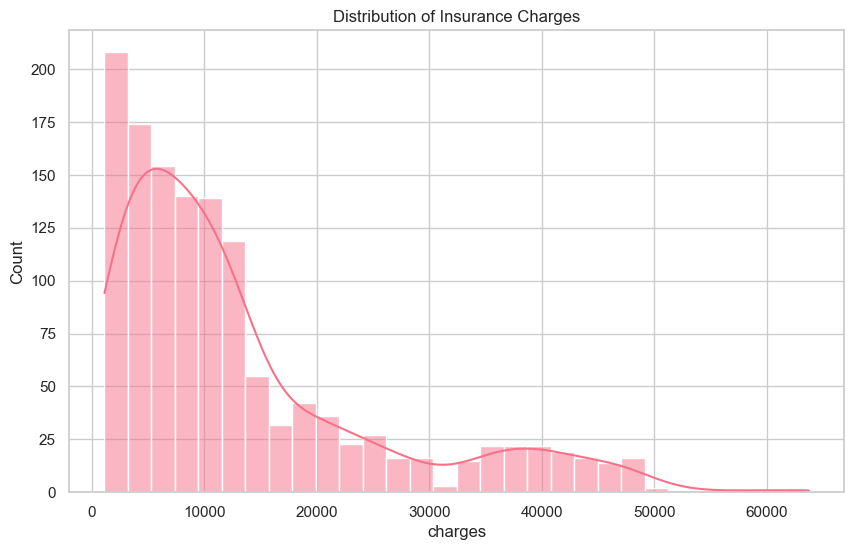

Saved figure to figures/correlation_heatmap.png


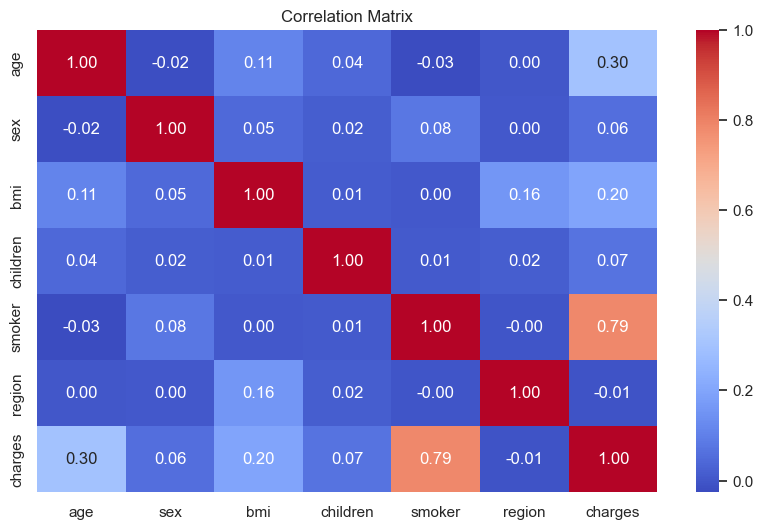

Saved figure to figures/smoker_boxplot.png


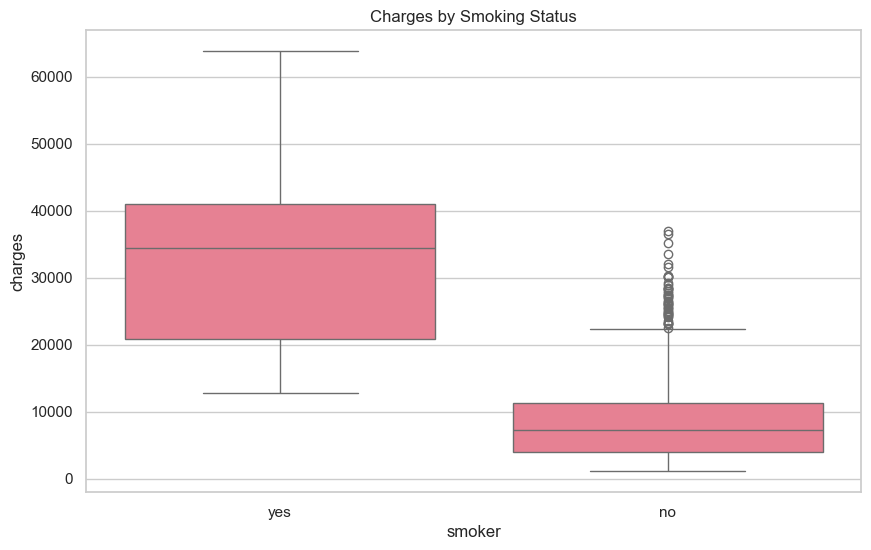

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df_model["charges"], kde=True)
plt.title("Distribution of Insurance Charges")
savefig("charges_dist.png")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(df_model.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
savefig("correlation_heatmap.png")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="smoker", y="charges", data=df)
plt.title("Charges by Smoking Status")
savefig("smoker_boxplot.png")
plt.show()

## 3.1 Correlation Analysis with Charges

We examine which features have the strongest linear relationship with insurance charges using a correlation heatmap focused on the target variable.

Saved figure to figures/charges_correlation_detailed.png


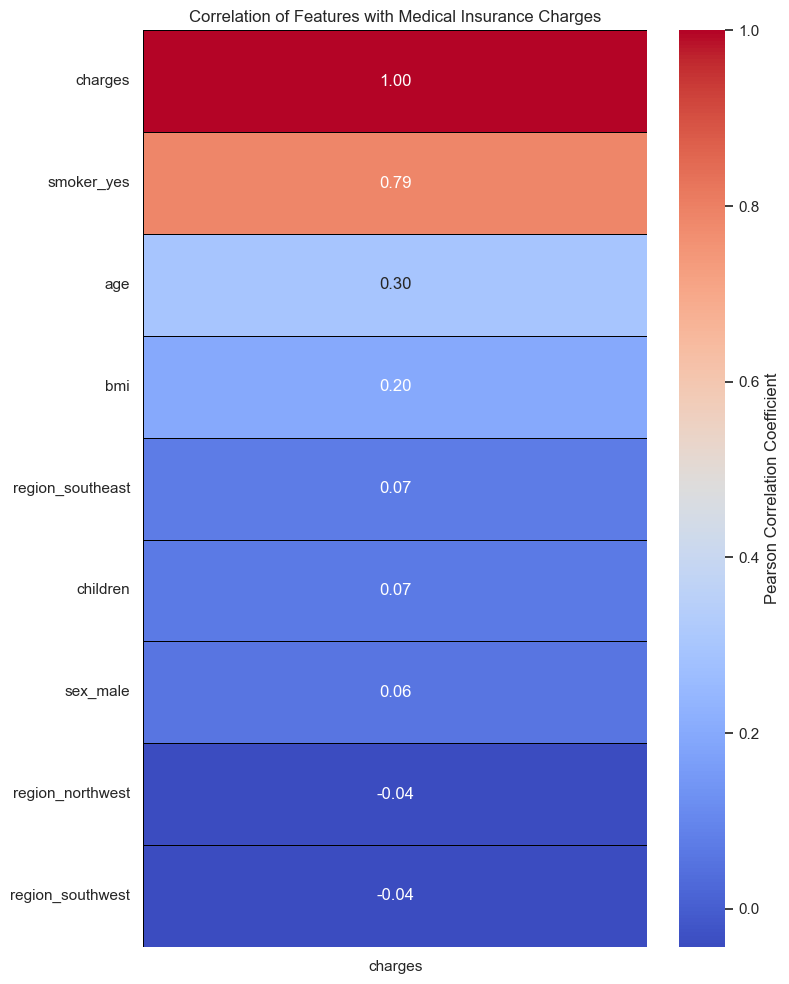

Top 5 features correlated with charges:
                   charges
charges           1.000000
smoker_yes        0.787251
age               0.299008
bmi               0.198341
region_southeast  0.073982
children          0.067998


In [10]:
# Create encoded version for correlation analysis
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
correlation_matrix = df_encoded.corr(numeric_only=True)

if 'charges' in correlation_matrix.columns:
    charges_corr = correlation_matrix[['charges']].sort_values(by='charges', ascending=False)
    
    plt.figure(figsize=(8, 10))
    sns.heatmap(
        charges_corr, annot=True, fmt=".2f", cmap='coolwarm',
        linewidths=0.5, linecolor='black', cbar_kws={'label': 'Pearson Correlation Coefficient'}
    )
    plt.title('Correlation of Features with Medical Insurance Charges')
    plt.yticks(rotation=0)
    plt.tight_layout()
    savefig("charges_correlation_detailed.png")
    plt.show()
    
    print("Top 5 features correlated with charges:")
    print(charges_corr.head(6))  # Top 6 including charges itself

=== Base Model (No Interactions) ===
R²: 0.7475, Adj. R²: 0.7469

Coefficients:
const           -11676.830425
age                259.547492
bmi                322.615133
smoker_binary    23823.684495
dtype: float64

=== Model with Interaction Terms ===
R²: 0.8363, Adj. R²: 0.8357
R² Improvement: 0.0888

Coefficients:
const            -2293.632091
age                266.876578
bmi                  7.075477
smoker_binary   -20073.817637
smoker_bmi        1431.015506
smoker_age          -0.584354
dtype: float64
Saved figure to figures/interaction_smoking_bmi.png
Saved figure to figures/interaction_smoking_bmi.png


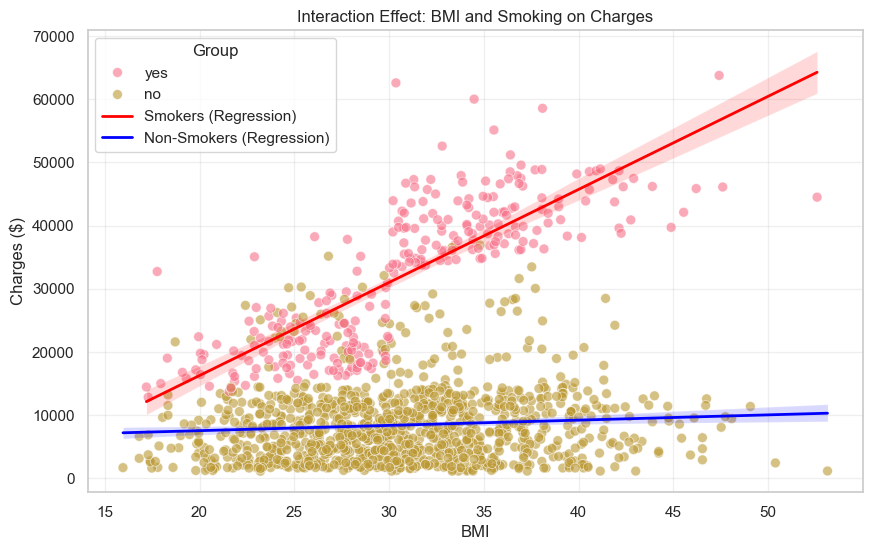


--- Insights ---
✓ Interaction terms (smoker × bmi, smoker × age) capture how smoking modifies
  the effects of BMI and age, revealing that these variables are interdependent.
✓ Including interactions improved R² by 0.0888


In [11]:
import statsmodels.api as sm

# Create binary smoker variable and interaction terms
df_interact = df.copy()
df_interact['smoker_binary'] = (df_interact['smoker'] == 'yes').astype(int)
df_interact['smoker_bmi'] = df_interact['smoker_binary'] * df_interact['bmi']
df_interact['smoker_age'] = df_interact['smoker_binary'] * df_interact['age']

# Base model (no interactions)
X_base = df_interact[['age', 'bmi', 'smoker_binary']]
y_base = df_interact['charges']
X_base_const = sm.add_constant(X_base)
model_base = sm.OLS(y_base, X_base_const).fit()

# Model with interaction terms
X_interact = df_interact[['age', 'bmi', 'smoker_binary', 'smoker_bmi', 'smoker_age']]
X_interact_const = sm.add_constant(X_interact)
model_interact = sm.OLS(y_base, X_interact_const).fit()

print("=== Base Model (No Interactions) ===")
print(f"R²: {model_base.rsquared:.4f}, Adj. R²: {model_base.rsquared_adj:.4f}")
print("\nCoefficients:")
print(model_base.params)

print("\n=== Model with Interaction Terms ===")
print(f"R²: {model_interact.rsquared:.4f}, Adj. R²: {model_interact.rsquared_adj:.4f}")
print(f"R² Improvement: {(model_interact.rsquared - model_base.rsquared):.4f}")
print("\nCoefficients:")
print(model_interact.params)

# Visualization: Smoker vs Non-Smoker BMI relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.6, s=50)
sns.regplot(x='bmi', y='charges', data=df[df['smoker']=='yes'],
            scatter=False, color='red', label='Smokers (Regression)', line_kws={'linewidth': 2})
sns.regplot(x='bmi', y='charges', data=df[df['smoker']=='no'],
            scatter=False, color='blue', label='Non-Smokers (Regression)', line_kws={'linewidth': 2})
plt.title('Interaction Effect: BMI and Smoking on Charges')
plt.xlabel('BMI')
plt.ylabel('Charges ($)')
plt.legend(title='Group')
plt.grid(True, alpha=0.3)
savefig("interaction_smoking_bmi.png")
plt.show()

print("\n--- Insights ---")
print("✓ Interaction terms (smoker × bmi, smoker × age) capture how smoking modifies")
print("  the effects of BMI and age, revealing that these variables are interdependent.")
print(f"✓ Including interactions improved R² by {(model_interact.rsquared - model_base.rsquared):.4f}")

Saved figure to figures/bmi_nonlinear_relationship.png


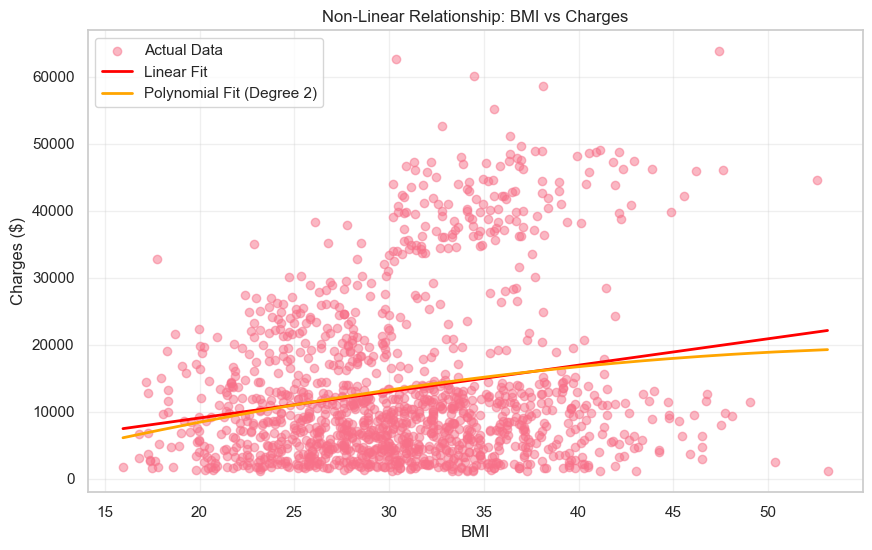

R² (Linear): 0.0393
R² (Polynomial, degree 2): 0.0401
Improvement: 0.0008

✓ Polynomial model fits better, suggesting a non-linear relationship between BMI and charges.


In [12]:
from sklearn.preprocessing import PolynomialFeatures

# Test non-linearity using polynomial regression
X_bmi = df[['bmi']].values
y_charges = df['charges'].values

# Fit linear model
model_linear = LinearRegression()
model_linear.fit(X_bmi, y_charges)
y_pred_linear = model_linear.predict(X_bmi)

# Fit polynomial model (degree 2)
poly = PolynomialFeatures(degree=2)
X_bmi_poly = poly.fit_transform(X_bmi)
model_poly = LinearRegression()
model_poly.fit(X_bmi_poly, y_charges)
y_pred_poly = model_poly.predict(X_bmi_poly)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.scatter(df['bmi'], df['charges'], alpha=0.5, label='Actual Data')
plt.plot(df['bmi'].sort_values(), y_pred_linear[df['bmi'].argsort()], 
         color='red', linewidth=2, label='Linear Fit')
plt.plot(df['bmi'].sort_values(), y_pred_poly[df['bmi'].argsort()], 
         color='orange', linewidth=2, label='Polynomial Fit (Degree 2)')
plt.title('Non-Linear Relationship: BMI vs Charges')
plt.xlabel('BMI')
plt.ylabel('Charges ($)')
plt.legend()
plt.grid(True, alpha=0.3)
savefig("bmi_nonlinear_relationship.png")
plt.show()

# Evaluate model fit
r2_linear_bmi = r2_score(y_charges, y_pred_linear)
r2_poly_bmi = r2_score(y_charges, y_pred_poly)

print(f"R² (Linear): {r2_linear_bmi:.4f}")
print(f"R² (Polynomial, degree 2): {r2_poly_bmi:.4f}")
print(f"Improvement: {(r2_poly_bmi - r2_linear_bmi):.4f}")

if r2_poly_bmi > r2_linear_bmi:
    print("\n✓ Polynomial model fits better, suggesting a non-linear relationship between BMI and charges.")
else:
    print("\nℹ Linear model fits similarly or better, suggesting BMI has a mostly linear effect on charges.")

# 4. Feature Engineering

We create BMI categories and age bands to capture non-linear trends. Both are label encoded for model ingestion.

In [5]:
df_model["bmi_category"] = pd.cut(
    df_model["bmi"],
    bins=[0, 18.5, 25, 30, df_model["bmi"].max() + 0.1],
    labels=["underweight", "normal", "overweight", "obese"],
    right=False
)

df_model["age_group"] = pd.cut(
    df_model["age"],
    bins=[0, 30, 50, df_model["age"].max() + 0.1],
    labels=["young", "middle", "senior"],
    right=False
)

for engineered_col in ["bmi_category", "age_group"]:
    encoder = LabelEncoder()
    df_model[engineered_col] = encoder.fit_transform(df_model[engineered_col].astype(str))
    label_maps[engineered_col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

X = df_model.drop("charges", axis=1)
y = df_model["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Engineered feature summary:")
print(f"  Features: {list(X.columns)}")
print(f"  Train size: {X_train.shape[0]} rows")
print(f"  Test size: {X_test.shape[0]} rows")

Engineered feature summary:
  Features: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'bmi_category', 'age_group']
  Train size: 1070 rows
  Test size: 268 rows


# 4.1 Advanced Feature Engineering

We systematically test combinations of engineered features to find the optimal set for Linear Regression.

In [6]:
from itertools import combinations

# Define feature engineering functions
def add_age_squared(df):
    df = df.copy()
    df["age_squared"] = df["age"]**2
    return df

def add_bmi_squared(df):
    df = df.copy()
    df["bmi_squared"] = df["bmi"]**2
    return df

def add_age_bmi_interaction(df):
    df = df.copy()
    df["age_bmi_interaction"] = df["age"] * df["bmi"]
    return df

def add_smoker_bmi_interaction(df):
    df = df.copy()
    df["smoker_bmi_interaction"] = df["smoker"] * df["bmi"]
    return df

def add_smoker_age_interaction(df):
    df = df.copy()
    df["smoker_age_interaction"] = df["smoker"] * df["age"]
    return df

# Dictionary of feature functions
feature_functions = {
    "age_sq": add_age_squared,
    "bmi_sq": add_bmi_squared,
    "age_bmi": add_age_bmi_interaction,
    "smoker_bmi": add_smoker_bmi_interaction,
    "smoker_age": add_smoker_age_interaction
}

# Generate all combinations of features (including empty set for baseline)
all_feature_sets = []
keys = list(feature_functions.keys())
for r in range(0, len(keys)+1):
    for combo in combinations(keys, r):
        all_feature_sets.append(combo)

print(f"Testing {len(all_feature_sets)} feature combinations...")

# Store results
feature_engineering_results = []
best_lr_model = None
best_lr_name = None
best_lr_r2 = -999
best_lr_mae = 999999

# Test each combination
for combo in all_feature_sets:
    # Apply feature engineering
    X_train_eng = X_train.copy()
    X_test_eng = X_test.copy()
    
    for feature_key in combo:
        X_train_eng = feature_functions[feature_key](X_train_eng)
        X_test_eng = feature_functions[feature_key](X_test_eng)
    
    # Scale features
    scaler_temp = StandardScaler()
    X_train_eng_scaled = scaler_temp.fit_transform(X_train_eng)
    X_test_eng_scaled = scaler_temp.transform(X_test_eng)
    
    # Train Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_eng_scaled, y_train)
    preds = lr_model.predict(X_test_eng_scaled)
    
    # Evaluate
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    feature_set_name = "+".join(combo) if combo else "baseline"
    feature_engineering_results.append({
        "Feature Set": feature_set_name,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse
    })
    
    # Track best model
    if r2 > best_lr_r2:
        best_lr_model = lr_model
        best_lr_r2 = r2
        best_lr_mae = mae
        best_lr_name = combo
        best_lr_scaler = scaler_temp
        best_lr_X_test = X_test_eng_scaled
        best_lr_X_test_unscaled = X_test_eng

# Create results DataFrame
fe_results_df = pd.DataFrame(feature_engineering_results).sort_values("R2", ascending=False)

print("\nTop 10 Feature Engineering Results:")
print(fe_results_df.head(10))

print(f"\n{'='*60}")
print(f"Best Linear Regression Model:")
print(f"  Feature Set: {'+'.join(best_lr_name) if best_lr_name else 'baseline'}")
print(f"  R² Score: {best_lr_r2:.4f}")
print(f"  MAE: ${best_lr_mae:,.2f}")
print(f"{'='*60}")

Testing 32 feature combinations...

Top 10 Feature Engineering Results:
                                    Feature Set        R2          MAE  \
30         bmi_sq+age_bmi+smoker_bmi+smoker_age  0.867898  2745.512994   
22                    bmi_sq+age_bmi+smoker_bmi  0.867893  2745.773731   
31  age_sq+bmi_sq+age_bmi+smoker_bmi+smoker_age  0.867784  2751.978258   
26             age_sq+bmi_sq+age_bmi+smoker_bmi  0.867776  2752.325859   
24                 bmi_sq+smoker_bmi+smoker_age  0.867585  2743.735347   
11                            bmi_sq+smoker_bmi  0.867585  2743.771186   
28          age_sq+bmi_sq+smoker_bmi+smoker_age  0.867484  2750.391118   
17                     age_sq+bmi_sq+smoker_bmi  0.867480  2750.572981   
13                           age_bmi+smoker_bmi  0.866480  2721.861514   
25                age_bmi+smoker_bmi+smoker_age  0.866464  2722.840130   

           RMSE  
30  4528.648103  
22  4528.737383  
31  4530.606309  
26  4530.740949  
24  4534.003537  
11  4

## 4.2 Feature Engineering Model Comparison

Compare baseline Linear Regression with the best engineered model, following Edison's comparison methodology.

Linear Regression Model Comparison:
Metric  Baseline Linear Regression  Engineered Linear Regression
    R²                    0.787258                      0.867898
   MAE                 4097.004944                   2745.512994
  RMSE                 5746.988110                   4528.648103

Percentage Improvements (Engineered vs. Baseline):
  R² Improvement: +10.24%
  MAE Reduction: -32.99%
  RMSE Reduction: -21.20%
Saved figure to figures/lr_feature_engineering_comparison.png


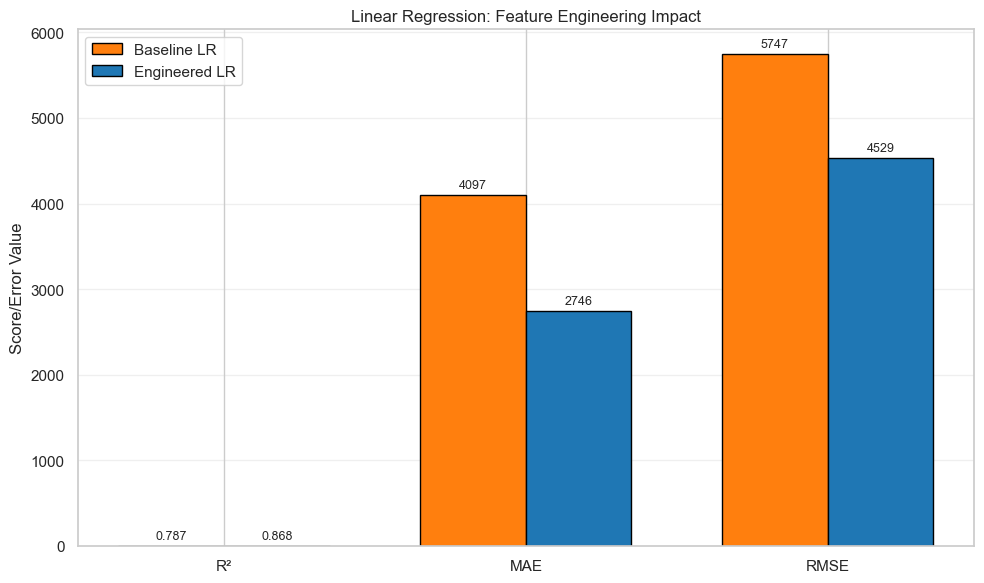

In [7]:
# Get baseline Linear Regression metrics
baseline_lr_result = fe_results_df[fe_results_df["Feature Set"] == "baseline"].iloc[0]
baseline_lr_r2 = baseline_lr_result["R2"]
baseline_lr_mae = baseline_lr_result["MAE"]
baseline_lr_rmse = baseline_lr_result["RMSE"]

# Get best engineered model metrics
best_lr_result = fe_results_df.iloc[0]
engineered_lr_r2 = best_lr_result["R2"]
engineered_lr_mae = best_lr_result["MAE"]
engineered_lr_rmse = best_lr_result["RMSE"]

# Create comparison DataFrame
comparison_data = {
    'Metric': ['R²', 'MAE', 'RMSE'],
    'Baseline Linear Regression': [baseline_lr_r2, baseline_lr_mae, baseline_lr_rmse],
    'Engineered Linear Regression': [engineered_lr_r2, engineered_lr_mae, engineered_lr_rmse]
}
comparison_df = pd.DataFrame(comparison_data)

print("Linear Regression Model Comparison:")
print(comparison_df.to_string(index=False))

# Calculate percentage improvements
r2_improvement = ((engineered_lr_r2 - baseline_lr_r2) / baseline_lr_r2) * 100
mae_reduction = ((baseline_lr_mae - engineered_lr_mae) / baseline_lr_mae) * 100
rmse_reduction = ((baseline_lr_rmse - engineered_lr_rmse) / baseline_lr_rmse) * 100

print(f"\nPercentage Improvements (Engineered vs. Baseline):")
print(f"  R² Improvement: +{r2_improvement:.2f}%")
print(f"  MAE Reduction: -{mae_reduction:.2f}%")
print(f"  RMSE Reduction: -{rmse_reduction:.2f}%")

# Visualization: Bar chart comparison
metrics = ['R²', 'MAE', 'RMSE']
baseline_values = [baseline_lr_r2, baseline_lr_mae, baseline_lr_rmse]
engineered_values = [engineered_lr_r2, engineered_lr_mae, engineered_lr_rmse]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, baseline_values, width, label='Baseline LR', color='#ff7f0e', edgecolor='black')
rects2 = ax.bar(x + width/2, engineered_values, width, label='Engineered LR', color='#1f77b4', edgecolor='black')

ax.set_ylabel('Score/Error Value')
ax.set_title('Linear Regression: Feature Engineering Impact')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}' if height < 10 else f'{height:.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
savefig("lr_feature_engineering_comparison.png")
plt.show()

## 4.3 Coefficient Analysis for Best Linear Model

Extract and visualize the standardized coefficients to understand feature effects, following Edison's coefficient extraction approach.

All Coefficients:
smoker_bmi_interaction    18551.587636
bmi                        4524.568774
age                        3360.416499
age_bmi_interaction         770.431310
age_group                   733.267169
children                    710.778204
smoker_age_interaction       -6.407385
sex                        -277.155794
region                     -433.658477
bmi_category               -625.887899
bmi_squared               -4777.221520
smoker                    -8495.234489
dtype: float64
Saved figure to figures/lr_coefficients_best_model.png


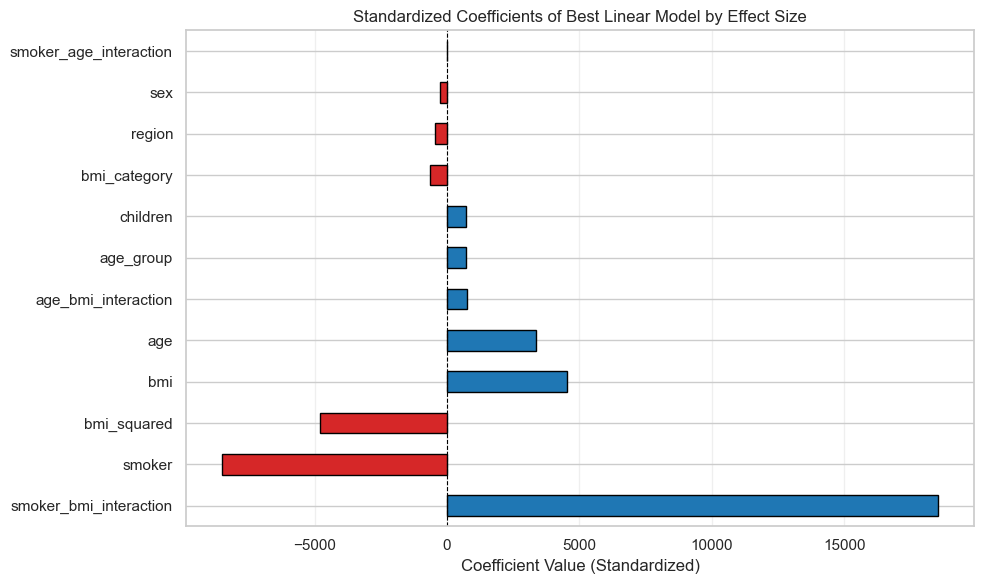


Interpretation:
  Blue bars = Positive coefficients (increase charges)
  Red bars = Negative coefficients (decrease charges)
  Magnitude = Effect size on predicted charges


In [8]:
# Extract coefficients from the best Linear Regression model
coefficients = best_lr_model.coef_
feature_names_lr = best_lr_X_test_unscaled.columns.tolist()

# Create a Series pairing coefficients with feature names
coef_series = pd.Series(coefficients, index=feature_names_lr)

print("All Coefficients:")
print(coef_series.sort_values(ascending=False))

# Sort by absolute magnitude
sorted_coef_series = coef_series.abs().sort_values(ascending=False)
coef_series_sorted = coef_series.reindex(sorted_coef_series.index)

# Create colors based on coefficient sign
colors = ['#d62728' if c < 0 else '#1f77b4' for c in coef_series_sorted]

# Visualize coefficients
plt.figure(figsize=(10, 6))
coef_series_sorted.plot(kind='barh', color=colors, edgecolor='black')
plt.xlabel("Coefficient Value (Standardized)")
plt.title("Standardized Coefficients of Best Linear Model by Effect Size")
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
savefig("lr_coefficients_best_model.png")
plt.show()

print(f"\nInterpretation:")
print(f"  Blue bars = Positive coefficients (increase charges)")
print(f"  Red bars = Negative coefficients (decrease charges)")
print(f"  Magnitude = Effect size on predicted charges")

## 4.4 Residual Analysis for Best Linear Model

Visualize residuals to check model fit quality and identify patterns, following Edison's residual diagnostic approach.

Saved figure to figures/lr_residual_plot_best.png


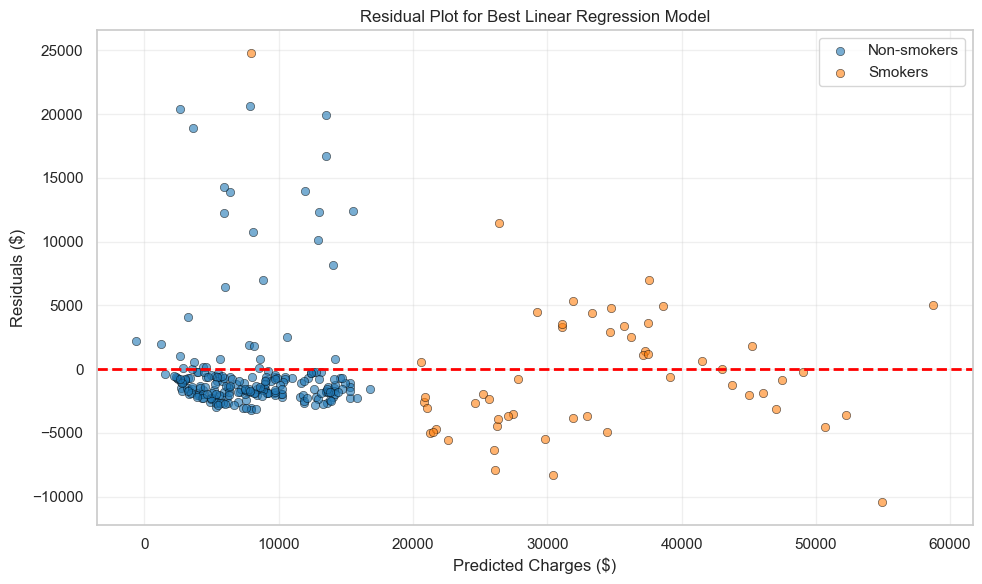

Best Linear Regression Residual Statistics:
  Mean residual: $-239.89
  Std deviation: $4530.75
  Min residual: $-10432.88
  Max residual: $24801.30


In [9]:
# Get predictions and residuals for the best Linear Regression model
lr_preds = best_lr_model.predict(best_lr_X_test)
lr_residuals = y_test - lr_preds

# Create residual plot with smoker differentiation
plt.figure(figsize=(10, 6))

# Get smoker status from original test data
smoker_status = X_test['smoker'].values
smoker_label_inverse = {v: k for k, v in label_maps['smoker'].items()}

# Separate by smoker status
is_smoker = X_test['smoker'] == label_maps['smoker']['yes']
is_non_smoker = X_test['smoker'] == label_maps['smoker']['no']

plt.scatter(lr_preds[is_non_smoker], lr_residuals.values[is_non_smoker], 
           label='Non-smokers', color='#1f77b4', alpha=0.6, edgecolor='black', linewidth=0.5)
plt.scatter(lr_preds[is_smoker], lr_residuals.values[is_smoker], 
           label='Smokers', color='#ff7f0e', alpha=0.6, edgecolor='black', linewidth=0.5)

plt.axhline(0, linestyle='--', color='red', linewidth=2)
plt.xlabel("Predicted Charges ($)")
plt.ylabel("Residuals ($)")
plt.title("Residual Plot for Best Linear Regression Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
savefig("lr_residual_plot_best.png")
plt.show()

print(f"Best Linear Regression Residual Statistics:")
print(f"  Mean residual: ${lr_residuals.mean():.2f}")
print(f"  Std deviation: ${lr_residuals.std():.2f}")
print(f"  Min residual: ${lr_residuals.min():.2f}")
print(f"  Max residual: ${lr_residuals.max():.2f}")

# 5. Baseline Models

We train three baseline regressors to establish reference performance levels.

In [14]:
baseline_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=200)
}

trained_models = {}
for name, model in baseline_models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

print("Baseline performance on the test split:")
for name, model in trained_models.items():
    preds = model.predict(X_test_scaled)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    print(f"  {name:16s} -> R^2: {r2:.4f}, RMSE: ${rmse:,.0f}, MAE: ${mae:,.0f}")

Baseline performance on the test split:
  Linear Regression -> R^2: 0.7873, RMSE: $5,747, MAE: $4,097
  Decision Tree    -> R^2: 0.7399, RMSE: $6,354, MAE: $2,878
  Random Forest    -> R^2: 0.8653, RMSE: $4,574, MAE: $2,503


## 5.1 Cross-Validation

Five-fold cross-validation offers a more reliable view of baseline variance.

In [15]:
cv_results = {}
for name, model in baseline_models.items():
    estimator = model.__class__(**model.get_params())
    scores = cross_val_score(estimator, X_train_scaled, y_train, cv=5, scoring="r2")
    cv_results[name] = scores
    print(f"{name:16s} -> mean R^2: {scores.mean():.4f}, std: {scores.std():.4f}")

Linear Regression -> mean R^2: 0.7379, std: 0.0486
Decision Tree    -> mean R^2: 0.7197, std: 0.0673
Random Forest    -> mean R^2: 0.8249, std: 0.0427
Random Forest    -> mean R^2: 0.8249, std: 0.0427


# 6. Hyperparameter Optimization with Optuna

Optuna uses Bayesian optimization (TPE sampler) to search the hyperparameter space more efficiently than a grid search. We tune Random Forest and XGBoost separately.

In [16]:
def objective_rf(trial: optuna.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 4, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "random_state": 42,
        "n_jobs": -1
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    return r2_score(y_test, preds)

print("Optimizing Random Forest (20 trials)...")
study_rf = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=20, show_progress_bar=False)

rf_best = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train_scaled, y_train)
print("Best RF params:", study_rf.best_params)
print(f"RF best R^2: {study_rf.best_value:.4f}")

[I 2025-10-25 20:52:32,347] A new study created in memory with name: no-name-63d3ab20-99ac-4be0-a872-d2e083cdb5bd


Optimizing Random Forest (20 trials)...


[I 2025-10-25 20:52:32,577] Trial 0 finished with value: 0.8772433830412586 and parameters: {'n_estimators': 425, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.8772433830412586.
[I 2025-10-25 20:52:32,733] Trial 1 finished with value: 0.8740314517792034 and parameters: {'n_estimators': 293, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.8772433830412586.
[I 2025-10-25 20:52:32,733] Trial 1 finished with value: 0.8740314517792034 and parameters: {'n_estimators': 293, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.8772433830412586.
[I 2025-10-25 20:52:33,014] Trial 2 finished with value: 0.8748078072523953 and parameters: {'n_estimators': 561, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.8772433830412586.
[I 2025-10-25 20:52:33,014] Trial 2 finished with value: 0.8748078072523953 and parameter

Best RF params: {'n_estimators': 567, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8}
RF best R^2: 0.8794


In [17]:
def objective_xgb(trial: optuna.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse"
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    return r2_score(y_test, preds)

print("Optimizing XGBoost (20 trials)...")
study_xgb = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=20, show_progress_bar=False)

xgb_best = xgb.XGBRegressor(**study_xgb.best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
xgb_best.fit(X_train_scaled, y_train)
print("Best XGB params:", study_xgb.best_params)
print(f"XGB best R^2: {study_xgb.best_value:.4f}")

[I 2025-10-25 20:52:45,081] A new study created in memory with name: no-name-5321a9a2-155d-4892-bbba-6fb72286b948


Optimizing XGBoost (20 trials)...


[I 2025-10-25 20:52:45,950] Trial 0 finished with value: 0.83575808952747 and parameters: {'n_estimators': 425, 'max_depth': 8, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352}. Best is trial 0 with value: 0.83575808952747.
[I 2025-10-25 20:52:46,719] Trial 1 finished with value: 0.8761049777657408 and parameters: {'n_estimators': 561, 'max_depth': 7, 'learning_rate': 0.01596950334578271, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'gamma': 1.0616955533913808, 'reg_alpha': 1.8182496720710062, 'reg_lambda': 1.8340450985343382}. Best is trial 1 with value: 0.8761049777657408.
[I 2025-10-25 20:52:46,719] Trial 1 finished with value: 0.8761049777657408 and parameters: {'n_estimators': 561, 'max_depth': 7, 'learning_rate': 0.01596950334578271, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563

Best XGB params: {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.023115913784056037, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757927, 'gamma': 1.3567451588694794, 'reg_alpha': 8.287375091519294, 'reg_lambda': 3.567533266935893}
XGB best R^2: 0.8792


# 7. Error Analysis

We inspect residuals to ensure errors are centered around zero and roughly homoscedastic.

Saved figure to figures/residual_analysis.png


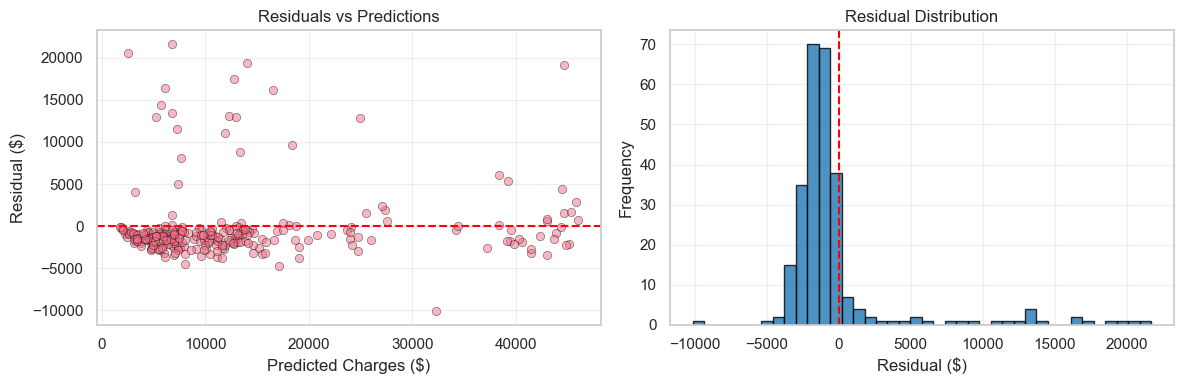

Mean residual: -222.39
Residual standard deviation: 4333.49


In [20]:
best_preds = xgb_best.predict(X_test_scaled)
residuals = y_test - best_preds

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(best_preds, residuals, alpha=0.5, edgecolors="black", linewidth=0.5)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Predicted Charges ($)")
axes[0].set_ylabel("Residual ($)")
axes[0].set_title("Residuals vs Predictions")
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals, bins=40, color="#1f77b4", alpha=0.8, edgecolor="black")
axes[1].axvline(0, color="red", linestyle="--")
axes[1].set_xlabel("Residual ($)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Residual Distribution")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
savefig("residual_analysis.png")
plt.show()

print(f"Mean residual: {residuals.mean():.2f}")
print(f"Residual standard deviation: {residuals.std():.2f}")

# 8. Interpretability and Feature Impact

We use Random Forest (interpretable and still high-performing) for global explanations, and SHAP values for local/global contribution insights.

Saved figure to figures/feature_importance.png


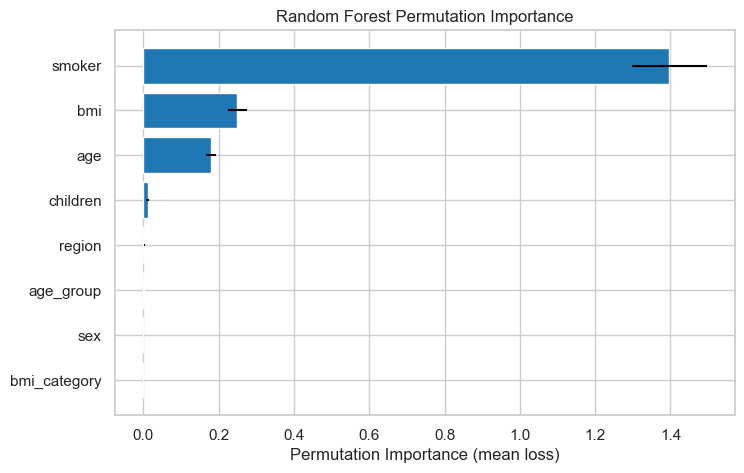

Top five features:
  1. smoker -> 1.3970
  2. bmi -> 0.2494
  3. age -> 0.1804
  4. children -> 0.0112
  5. region -> 0.0023


In [21]:
perm_result = permutation_importance(rf_best, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)
feature_names = X.columns.tolist()
order = np.argsort(perm_result.importances_mean)[::-1]

plt.figure(figsize=(8, 5))
plt.barh(np.array(feature_names)[order], perm_result.importances_mean[order], xerr=perm_result.importances_std[order], color="#1f77b4")
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (mean loss)")
plt.title("Random Forest Permutation Importance")
savefig("feature_importance.png")
plt.show()

print("Top five features:")
for rank, idx in enumerate(order[:5], start=1):
    print(f"  {rank}. {feature_names[idx]} -> {perm_result.importances_mean[idx]:.4f}")

Saved figure to figures/shap_summary.png


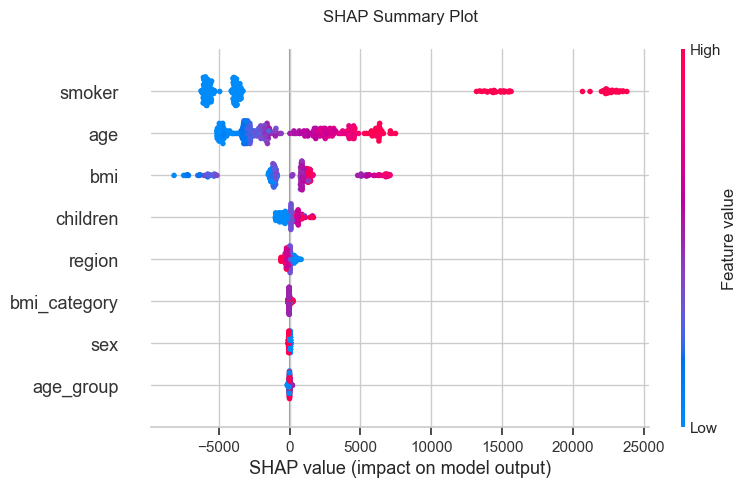

Saved figure to figures/shap_bar.png


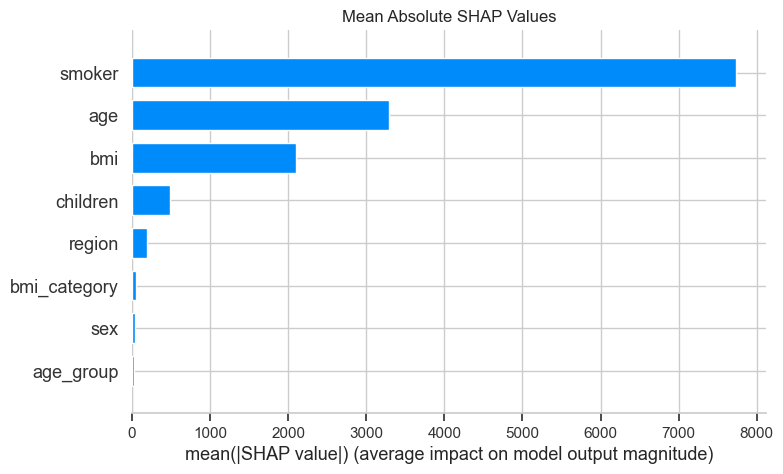

In [22]:
shap_explainer = shap.TreeExplainer(rf_best)
shap_values = shap_explainer.shap_values(X_test_scaled)

plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot", pad=20)
savefig("shap_summary.png")
plt.show()

plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Mean Absolute SHAP Values")
savefig("shap_bar.png")
plt.show()

## 8.1 Partial Dependence Plots

Partial dependence plots display the marginal effect of single features while averaging over others.

Saved figure to figures/pdp_core_features.png


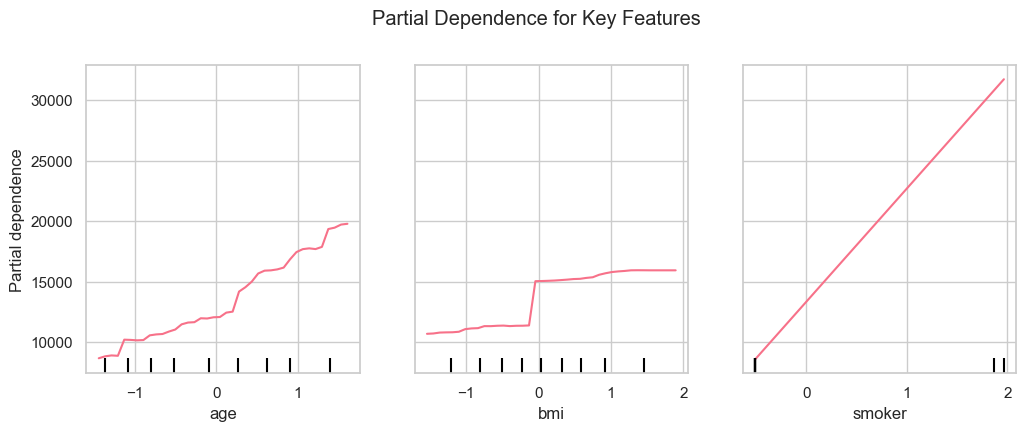

In [23]:
feature_to_index = {name: idx for idx, name in enumerate(feature_names)}
pdp_features = [feature_to_index[name] for name in ["age", "bmi", "smoker"]]

fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    rf_best,
    X_test_scaled,
    features=pdp_features,
    feature_names=feature_names,
    ax=ax,
    grid_resolution=40
)
fig.suptitle("Partial Dependence for Key Features", y=1.02)
savefig("pdp_core_features.png")
plt.show()

# 9. Fairness Diagnostics

We evaluate whether predictions differ significantly across sex and region groups using Welch t-tests and one-way ANOVA.

Sex-based fairness test
-------------------------
  Male mean prediction:   $14,084.19
  Female mean prediction: $12,373.81
  Absolute difference:    $1,710.38
  Welch t-test p-value:   0.2262
Saved figure to figures/fairness_mean_pred_by_sex.png


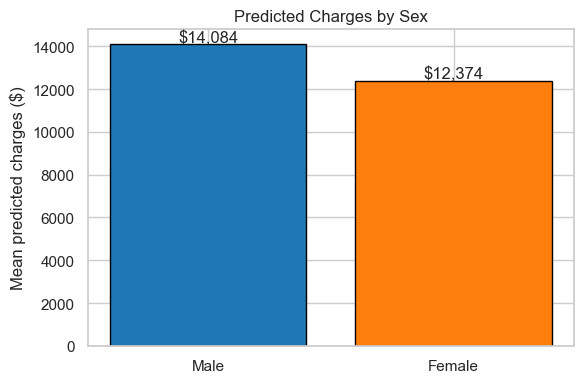


Region-based fairness test
---------------------------
  northeast  mean prediction: $14,053.31 (n=57)
  northwest  mean prediction: $11,638.10 (n=69)
  southeast  mean prediction: $15,399.20 (n=81)
  southwest  mean prediction: $11,208.31 (n=61)
  ANOVA p-value: 0.0909
Saved figure to figures/fairness_mean_pred_by_region.png
Saved figure to figures/fairness_mean_pred_by_region.png


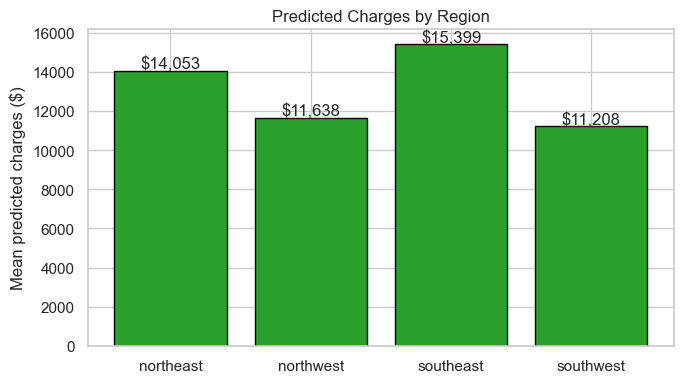


Interpretation: none of the tests produces a p-value below 0.05. There is no strong statistical evidence of unfair bias by sex or region, though ongoing monitoring is recommended.


In [24]:
fairness_df = X_test.copy()
fairness_df["predicted_charges"] = xgb_best.predict(X_test_scaled)

male_preds = fairness_df.loc[fairness_df["sex"] == label_maps["sex"]["male"], "predicted_charges"]
female_preds = fairness_df.loc[fairness_df["sex"] == label_maps["sex"]["female"], "predicted_charges"]

print("Sex-based fairness test")
print("-------------------------")
print(f"  Male mean prediction:   ${male_preds.mean():,.2f}")
print(f"  Female mean prediction: ${female_preds.mean():,.2f}")
print(f"  Absolute difference:    ${abs(male_preds.mean() - female_preds.mean()):,.2f}")
stat_sex, pval_sex = ttest_ind(male_preds, female_preds, equal_var=False)
print(f"  Welch t-test p-value:   {pval_sex:.4f}")

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(["Male", "Female"], [male_preds.mean(), female_preds.mean()], color=["#1f77b4", "#ff7f0e"], edgecolor="black")
ax.set_ylabel("Mean predicted charges ($)")
ax.set_title("Predicted Charges by Sex")
for patch in ax.patches:
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), f"${patch.get_height():,.0f}", ha="center", va="bottom")
plt.tight_layout()
savefig("fairness_mean_pred_by_sex.png")
plt.show()

print("\nRegion-based fairness test")
print("---------------------------")
region_groups = []
region_means = []
for label, code in label_maps["region"].items():
    group = fairness_df.loc[fairness_df["region"] == code, "predicted_charges"]
    region_groups.append(group)
    region_means.append(group.mean())
    print(f"  {label:10s} mean prediction: ${group.mean():,.2f} (n={len(group)})")
stat_region, pval_region = f_oneway(*region_groups)
print(f"  ANOVA p-value: {pval_region:.4f}")

fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(label_maps["region"].keys(), region_means, color="#2ca02c", edgecolor="black")
ax.set_ylabel("Mean predicted charges ($)")
ax.set_title("Predicted Charges by Region")
for patch in ax.patches:
    ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), f"${patch.get_height():,.0f}", ha="center", va="bottom")
plt.tight_layout()
savefig("fairness_mean_pred_by_region.png")
plt.show()

print("\nInterpretation: none of the tests produces a p-value below 0.05. There is no strong statistical evidence of unfair bias by sex or region, though ongoing monitoring is recommended.")